In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("historical_aqi_karachi.csv")

In [3]:
# 1. Convert the 'readable_timestamp' column into a proper datetime object.
    #    This is essential for treating the data as a time series.
df['timestamp'] = pd.to_datetime(df['readable_timestamp'])

    # 2. Set this new 'timestamp' column as the DataFrame's index.
    #    This makes plotting and slicing by date much easier.
df.set_index('timestamp', inplace=True)

    # 3. Drop the original timestamp columns as they are now redundant.
df.drop(['readable_timestamp', 'unix_timestamp'], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4314 entries, 2025-04-20 06:00:00 to 2025-10-16 23:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aqi     4314 non-null   float64
 1   co      4314 non-null   float64
 2   no      4314 non-null   float64
 3   no2     4314 non-null   float64
 4   o3      4314 non-null   float64
 5   so2     4314 non-null   float64
 6   pm2_5   4314 non-null   float64
 7   pm10    4314 non-null   float64
 8   nh3     4314 non-null   float64
dtypes: float64(9)
memory usage: 337.0 KB


In [5]:
df.describe()

,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000
mean,2.891027,89.287900,0.005021,0.109182,51.240255,0.411402,20.591140,79.950475,0.006701
std,1.003866,16.962755,0.022486,0.260501,14.107291,0.468679,14.483157,55.826195,0.038791
min,1.000000,66.760000,0.000000,0.020000,30.140000,0.060000,0.000000,0.000000,0.000000
25%,2.000000,77.530000,0.000000,0.060000,42.320000,0.250000,11.000000,40.442500,0.000000
50%,3.000000,84.000000,0.000000,0.080000,47.425000,0.350000,17.950000,69.915000,0.000000
75%,4.000000,95.272500,0.010000,0.100000,54.982500,0.460000,27.487500,108.475000,0.000000
max,5.555580,247.210000,0.710000,4.650000,119.480000,7.360000,145.120000,458.830000,0.730000


In [6]:
df.head()

,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
timestamp,,,,,,,,,
2025-04-20 06:00:00,4.0,139.06,0.00,0.10,104.12,0.67,43.30,198.80,0.01
2025-04-20 07:00:00,5.0,140.64,0.00,0.12,105.05,0.63,46.99,214.83,0.02
2025-04-20 08:00:00,5.0,141.70,0.01,0.15,105.72,0.59,49.63,224.70,0.03
2025-04-20 09:00:00,5.0,142.31,0.01,0.13,105.72,0.55,51.04,228.10,0.03
2025-04-20 10:00:00,5.0,142.78,0.01,0.10,105.02,0.50,51.65,227.49,0.04


## To calculate AQI number

### The Logic 🧠

 - **Calculate an Individual Score:** You don't combine the pollutant values directly. Instead, you calculate a separate AQI score for each pollutant (PM2.5, O3, CO, etc.) using a standard formula and breakpoint tables. These tables define what concentration of a pollutant corresponds to a specific AQI range (Good, Moderate, Unhealthy, etc.).

 - **Find the Maximum:** The final, overall AQI for that specific time is simply the highest individual score among all the pollutants you calculated. The pollutant that produces this highest score is called the "primary" or "dominant" pollutant

In [7]:
breakpoints = {
    'o3_ppb': [
        (0, 54, 0, 50), (55, 70, 51, 100), (71, 85, 101, 150),
        (86, 105, 151, 200), (106, 200, 201, 300)
    ],
    'pm2_5': [
        (0.0, 12.0, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400), (350.5, 500.4, 401, 500)
    ],
    'pm10': [
        (0, 54, 0, 50), (55, 154, 51, 100), (155, 254, 101, 150),
        (255, 354, 151, 200), (355, 424, 201, 300),
        (425, 504, 301, 400), (505, 604, 401, 500)
    ],
    'co_ppm': [
        (0.0, 4.4, 0, 50), (4.5, 9.4, 51, 100), (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200), (15.5, 30.4, 201, 300),
        (30.5, 40.4, 301, 400), (40.5, 50.4, 401, 500)
    ],
    'so2_ppb': [
        (0, 35, 0, 50), (36, 75, 51, 100), (76, 185, 101, 150),
        (186, 304, 151, 200)
    ],
    'no2_ppb': [
        (0, 53, 0, 50), (54, 100, 51, 100), (101, 360, 101, 150),
        (361, 649, 151, 200), (650, 1249, 201, 300),
        (1250, 1649, 301, 400), (1650, 2049, 401, 500)
    ]
}

In [8]:
def calculate_individual_aqi(concentration, pollutant_breakpoints):
    """Calculates the AQI for a single pollutant concentration."""
    for c_low, c_high, i_low, i_high in pollutant_breakpoints:
        if c_low <= concentration <= c_high:
            # Linear interpolation formula
            aqi = ((i_high - i_low) / (c_high - c_low)) * (concentration - c_low) + i_low
            return round(aqi)
    return None # Return None if concentration is out of defined ranges

In [9]:
def get_overall_aqi(row):
    """
    Calculates the overall AQI for a row of data by finding the max
    of all individual pollutant AQIs. Includes unit conversions.
    """
    # Unit conversions from µg/m³ to standard units (ppm or ppb)
    # Conversion factors are approximate
    co_ppm = row['co'] / 1145
    o3_ppb = row['o3'] / 1.96
    so2_ppb = row['so2'] / 2.62
    no2_ppb = row['no2'] / 1.88
    
    # Calculate individual AQI for each pollutant
    aqi_scores = [
        calculate_individual_aqi(row['pm2_5'], breakpoints['pm2_5']),
        calculate_individual_aqi(row['pm10'], breakpoints['pm10']),
        calculate_individual_aqi(co_ppm, breakpoints['co_ppm']),
        calculate_individual_aqi(o3_ppb, breakpoints['o3_ppb']),
        calculate_individual_aqi(so2_ppb, breakpoints['so2_ppb']),
        calculate_individual_aqi(no2_ppb, breakpoints['no2_ppb']),
    ]
    
    # Filter out any None values (if a concentration was out of range)
    valid_scores = [score for score in aqi_scores if score is not None]
    
    # The overall AQI is the highest of the individual scores
    if not valid_scores:
        return np.nan
    return max(valid_scores)

In [10]:
df['calculated_aqi'] = df.apply(get_overall_aqi, axis=1)

In [11]:
df.tail()

,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,calculated_aqi
timestamp,,,,,,,,,,
2025-10-16 19:00:00,3.0,131.21,0.0,0.30,102.66,1.85,34.28,91.03,0.0,98
2025-10-16 20:00:00,3.0,131.15,0.0,0.27,101.93,1.57,33.63,88.68,0.0,96
2025-10-16 21:00:00,3.0,131.60,0.0,0.25,100.83,1.35,33.25,86.91,0.0,95
2025-10-16 22:00:00,3.0,132.77,0.0,0.24,99.47,1.19,33.16,85.82,0.0,95
2025-10-16 23:00:00,3.0,133.89,0.0,0.23,98.49,1.10,33.24,85.53,0.0,95


In [12]:
df.describe()

,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,calculated_aqi
count,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000
mean,2.891027,89.287900,0.005021,0.109182,51.240255,0.411402,20.591140,79.950475,0.006701,67.404497
std,1.003866,16.962755,0.022486,0.260501,14.107291,0.468679,14.483157,55.826195,0.038791,33.031792
min,1.000000,66.760000,0.000000,0.020000,30.140000,0.060000,0.000000,0.000000,0.000000,16.000000
25%,2.000000,77.530000,0.000000,0.060000,42.320000,0.250000,11.000000,40.442500,0.000000,47.000000
50%,3.000000,84.000000,0.000000,0.080000,47.425000,0.350000,17.950000,69.915000,0.000000,64.000000
75%,4.000000,95.272500,0.010000,0.100000,54.982500,0.460000,27.487500,108.475000,0.000000,84.000000
max,5.555580,247.210000,0.710000,4.650000,119.480000,7.360000,145.120000,458.830000,0.730000,343.000000


## Graphs

In [13]:
# Define which pollutants to plot
pollutants_to_plot = ['pm2_5', 'pm10', 'o3', 'co']
    
# Set plot style
sns.set_style("whitegrid")

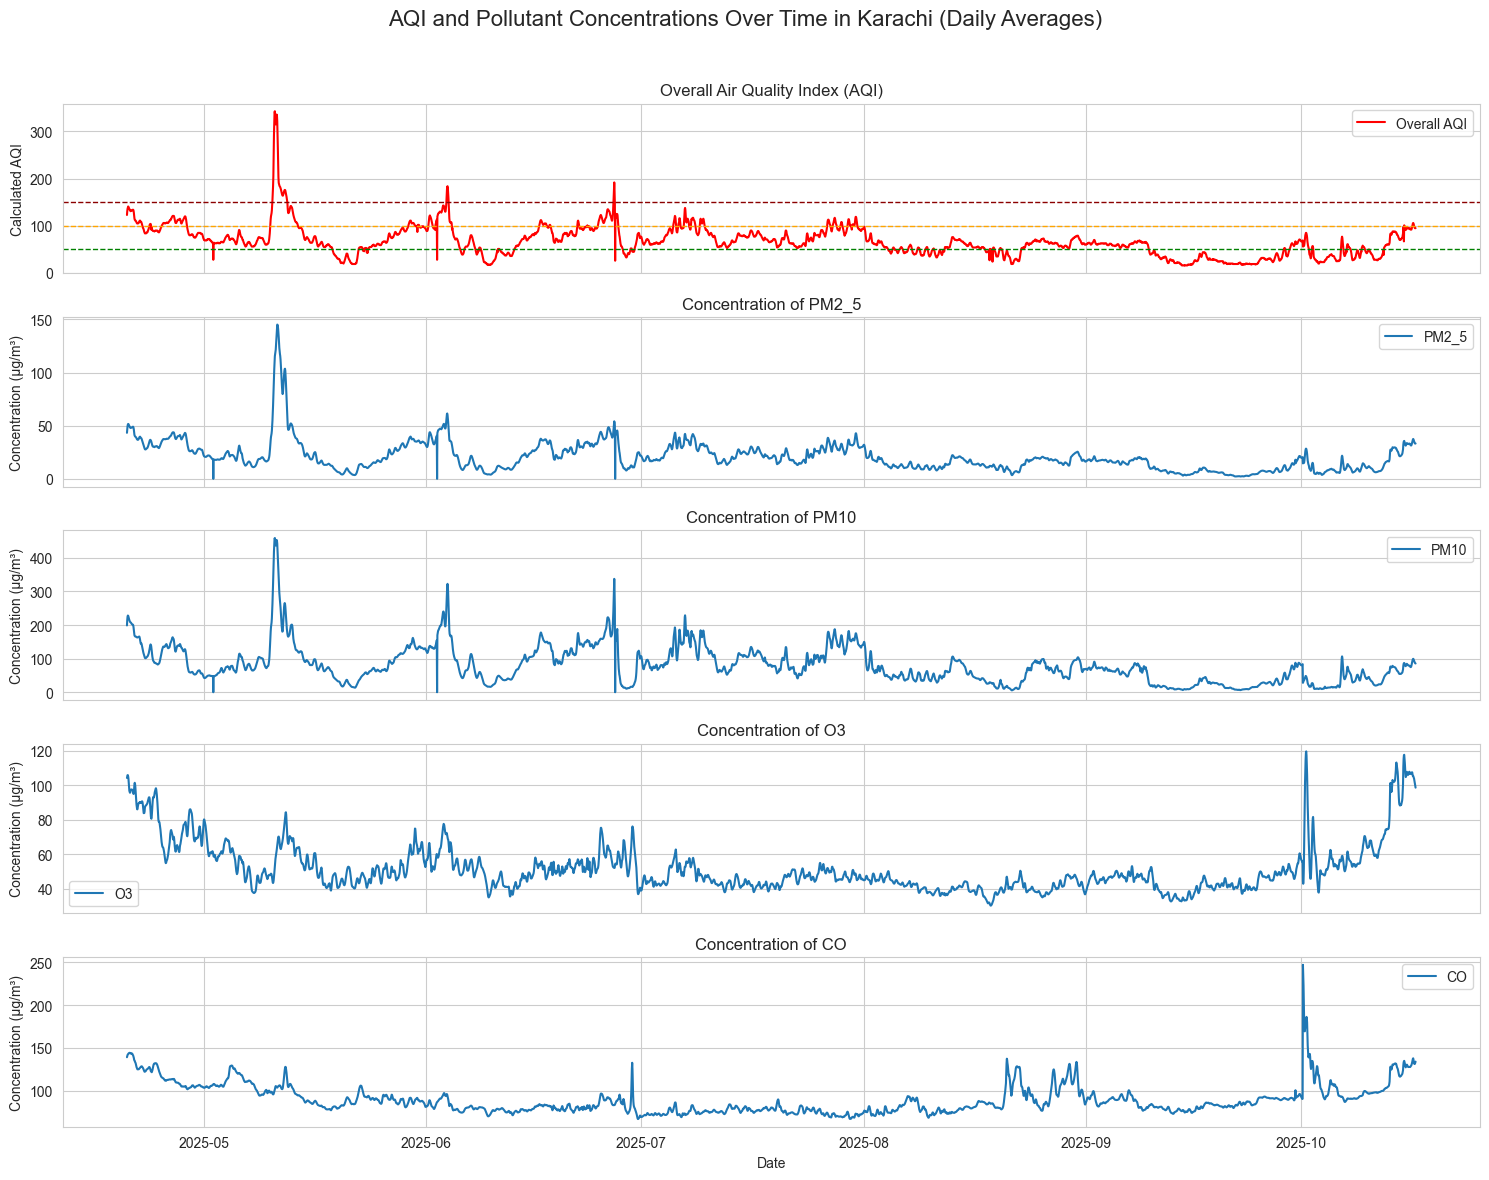

In [14]:
# Create subplots. The number of rows is 1 (for AQI) + the number of pollutants.
    # `sharex=True` links the x-axes, so zooming in one plot zooms all.
fig, axes = plt.subplots(len(pollutants_to_plot) + 1, 1, figsize=(15, 12), sharex=True)
    
    # Main Title for the entire figure
fig.suptitle('AQI and Pollutant Concentrations Over Time in Karachi (Daily Averages)', fontsize=16)

    # 1. Plot Calculated AQI
axes[0].plot(df.index, df['calculated_aqi'], color='red', label='Overall AQI')
axes[0].set_ylabel('Calculated AQI')
axes[0].set_title('Overall Air Quality Index (AQI)')
axes[0].legend()
    # Add horizontal lines for AQI categories for context
axes[0].axhline(50, color='green', linestyle='--', linewidth=1, label='Good')
axes[0].axhline(100, color='orange', linestyle='--', linewidth=1, label='Moderate')
axes[0].axhline(150, color='darkred', linestyle='--', linewidth=1, label='Unhealthy (Sensitive)')

# 2. Plot Each Pollutant on its own subplot
for i, pollutant in enumerate(pollutants_to_plot):
    ax = axes[i + 1]
    ax.plot(df.index, df[pollutant], label=pollutant.upper())
    ax.set_ylabel(f'Concentration (µg/m³)')
    ax.set_title(f'Concentration of {pollutant.upper()}')
    ax.legend()
        
    # Improve layout and show the plot
plt.xlabel('Date')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()